In [1]:
import hopsworks
import pandas as pd
from sklearn.linear_model import LinearRegression, Lasso
from sklearn import ensemble
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
from matplotlib import pyplot
from hsml.schema import Schema
from hsml.model_schema import ModelSchema
import joblib
import os
import numpy as np
from sklearn.metrics import mean_squared_error


/Users/robingoran/miniconda3/envs/lab1serveerless/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# You have to set the environment variable 'HOPSWORKS_API_KEY' for login to succeed
project = hopsworks.login()
fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/224406
Connected. Call `.close()` to terminate connection gracefully.


In [18]:
# The feature view is the input set of features for your model. The features can come from different feature groups.    
# You can select features from different feature groups and join them together to create a feature view
wine_fg = fs.get_feature_group(name="winedataset", version=1)
query = wine_fg.select_all()
transformation_functions = {}


Transformation of the data in form of normalization is done when creating the view below

In [17]:

min_max_scaler = fs.get_transformation_function(name="min_max_scaler")

wine_fg_features = wine_fg.select_except(features=['quality', 'type_red', 'type_white']).features

for row in wine_fg_features:
    print(row.name)

# construct dictionary of "feature - transformation function" pairs
transformation_functions = {col.name: min_max_scaler for col in wine_fg_features}

fixed_acidity
volatile_acidity
citric_acid
residual_sugar
chlorides
total_sulfur_dioxide
ph
sulphates
alcohol
sulfur_dioxide_ratio


In [19]:
#Create feature view
feature_view = fs.get_or_create_feature_view(name="wineviewnotnormalized",
                                  version=1,
                                  description="Read from wine dataset, no ph or residual sugar",
                                  labels=["quality"],
                                  transformation_functions = transformation_functions,
                                  query=query)

Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/224406/fs/224325/fv/wineviewnotnormalized/version/1


In [20]:
#Split data
X_train, X_test, y_train, y_test = feature_view.train_test_split(0.2)

Finished: Reading data from Hopsworks, using ArrowFlight (2.41s) 


In [83]:
#Lasso regression

model = Lasso(alpha=0.001)  # You can adjust the alpha (regularization strength)


In [21]:
#Random forest

model =  ensemble.RandomForestClassifier(
    n_estimators=700,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='log2',
    random_state=42  # Set a random state for reproducibility
)


score of model is :  0.5845864661654135
{'3': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 3}, '4': {'precision': 0.42857142857142855, 'recall': 0.06666666666666667, 'f1-score': 0.11538461538461539, 'support': 45}, '5': {'precision': 0.66, 'recall': 0.6398891966759003, 'f1-score': 0.6497890295358649, 'support': 361}, '6': {'precision': 0.551433389544688, 'recall': 0.7234513274336283, 'f1-score': 0.6258373205741626, 'support': 452}, '7': {'precision': 0.5315315315315315, 'recall': 0.34911242603550297, 'f1-score': 0.42142857142857143, 'support': 169}, '8': {'precision': 0.6666666666666666, 'recall': 0.06060606060606061, 'f1-score': 0.1111111111111111, 'support': 33}, '9': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 1}, 'accuracy': 0.5845864661654135, 'macro avg': {'precision': 0.4054575737591878, 'recall': 0.26281795391682267, 'f1-score': 0.2747929497191894, 'support': 1064}, 'weighted avg': {'precision': 0.581412063147314, 'recall': 0.5845864661654135,

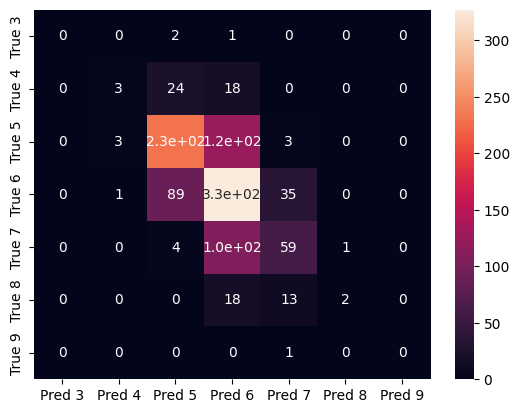

In [22]:
# Train the model
model.fit(X_train, y_train.values.ravel())

y_pred = model.predict(X_test)


# Evaluate the performance using Mean Squared Error and then round if Regression is used
#mse = mean_squared_error(y_test, y_pred)
#print("Mean Squared Error:", mse)
#y_pred = np.round(y_pred).astype(int)

# Compare predictions (y_pred) with the labels in the test set (y_test)
metrics = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
results = confusion_matrix(y_test, y_pred)

rnd_score = model.score(X_test,y_test)
print('score of model is : ',rnd_score)

#Dålig på 5,6,7 - lika varandra? Var är 9?
print(metrics)

df_cm = pd.DataFrame(results, ['True 3', 'True 4', 'True 5', 'True 6','True 7','True 8', 'True 9'],
                     ['Pred 3', 'Pred 4', 'Pred 5', 'Pred 6', 'Pred 7', 'Pred 8', 'Pred 9'])
#df_cm = pd.DataFrame(results)
cm = sns.heatmap(df_cm, annot=True)
fig = cm.get_figure()

In [23]:
mr = project.get_model_registry()


model_dir="wine_model"

if os.path.isdir(model_dir) == False:
    os.mkdir(model_dir)

# Save both our model and the confusion matrix to 'model_dir', whose contents will be uploaded to the model registry
joblib.dump(model, model_dir + "/wine_model.pkl")
fig.savefig(model_dir + "/confusion_matrix.png")    

# Specify the schema of the model's input/output using the features (X_train) and labels (y_train)
input_schema = Schema(X_train)
output_schema = Schema(y_train)
model_schema = ModelSchema(input_schema, output_schema)

# Create an entry in the model registry that includes the model's name, desc, metrics
wine_model = mr.python.create_model(
    name="wine_model_randomforest", 
    metrics={"Accuracy" : metrics['weighted avg']['precision']},
    model_schema=model_schema,
    description="Wine Quality Predictor"
)

# Upload the model to the model registry, including all files in 'model_dir'
wine_model.save(model_dir)

Connected. Call `.close()` to terminate connection gracefully.


Uploading: 100.000%|██████████| 28962/28962 elapsed<00:01 remaining<00:001,  3.08it/s]
Uploading: 100.000%|██████████| 176453425/176453425 elapsed<01:36 remaining<00:00it/s]
Uploading: 100.000%|██████████| 1070/1070 elapsed<00:01 remaining<00:003:52, 58.17s/it]
Model export complete: 100%|██████████| 6/6 [01:46<00:00, 17.80s/it]                   

Model created, explore it at https://c.app.hopsworks.ai:443/p/224406/models/wine_model_randomforest/2


Model(name: 'wine_model_randomforest', version: 2)